In [1]:
import torch
import torch.nn as nn
from torchvision import models

device = 'cuda'

densenet121 = models.densenet121(pretrained=True)

for param in densenet121.parameters():
    param.requires_grad = False

num_features = densenet121.classifier.in_features 

densenet121.classifier = nn.Linear(num_features, 7)
densenet121.to(device)
for param in densenet121.classifier.parameters():
    param.requires_grad = True

c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Creating the DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

# Load and prepare the dataset
data = pd.read_csv('HAM10000_metadata_paths.csv')
data['image_path'] = data['image_path'].str.replace('\\', '/')
mapping = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'bcc': 4, 'akiec': 5, 'vasc': 6}
X = data['image_path']
y = data['dx'].map(mapping)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class HAM(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HAM(X_train, y_train, transform=transform)
val_dataset = HAM(X_val, y_val, transform=transform)
test_dataset = HAM(X_test, y_test, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
optimizer = torch.optim.Adam(densenet121.classifier.parameters(), lr=0.005)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda'
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
loss_fn = nn.CrossEntropyLoss()

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device='cuda'):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    torch.save(model.state_dict(), 'densenet121_model.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [4]:
train_losses, train_accuracies, val_losses, val_accuracies = train(densenet121, optimizer, loss_fn, train_loader, val_loader, epochs=3, device='cuda')
print(f'Training Losses: {train_losses}')
print(f'Training Accuracies: {train_accuracies}')
print(f'Validation Losses: {val_losses}')
print(f'Validation Accuracies: {val_accuracies}')

Epoch: 0
Epoch 1: Train Loss: 0.8134, Train Accuracy: 0.7245, Val Loss: 0.7487, Val Accuracy: 0.7253
Epoch: 1
Epoch 2: Train Loss: 0.6493, Train Accuracy: 0.7572, Val Loss: 0.6656, Val Accuracy: 0.7483
Epoch: 2
Epoch 3: Train Loss: 0.5808, Train Accuracy: 0.7893, Val Loss: 0.6684, Val Accuracy: 0.7642
Training Losses: [0.8134194044839769, 0.6493453366888894, 0.5808071129851871]
Training Accuracies: [0.7245381927109336, 0.7572391412880679, 0.7893160259610584]
Validation Losses: [0.7487086802721024, 0.6656434386968613, 0.6683963872492313]
Validation Accuracies: [0.7252747252747253, 0.7482517482517482, 0.7642357642357642]


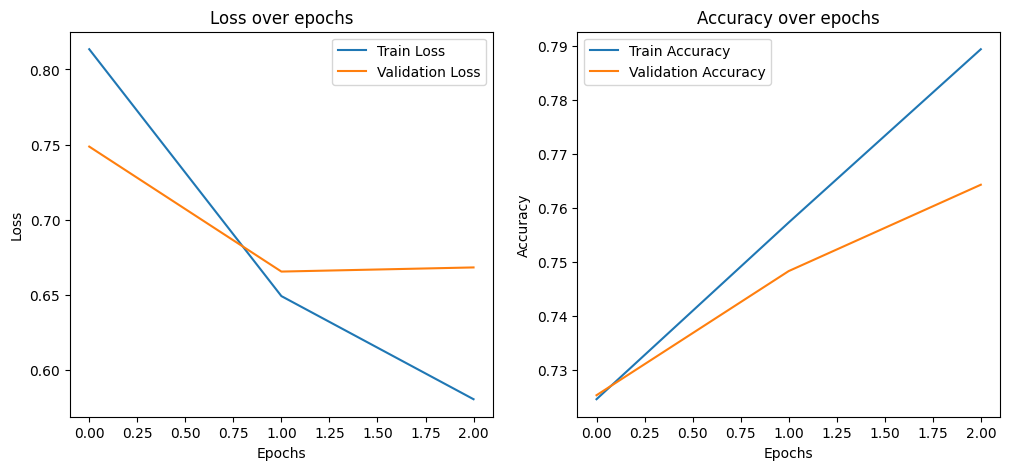

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
densenet121.eval()
test_loss, correct, all_predictions, all_targets = 0, 0, [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet121(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.view(-1).tolist())
        all_targets.extend(labels.view(-1).tolist())
    
test_loss /= len(test_loader)
test_accuracy = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5985, Test Accuracy: 0.7864


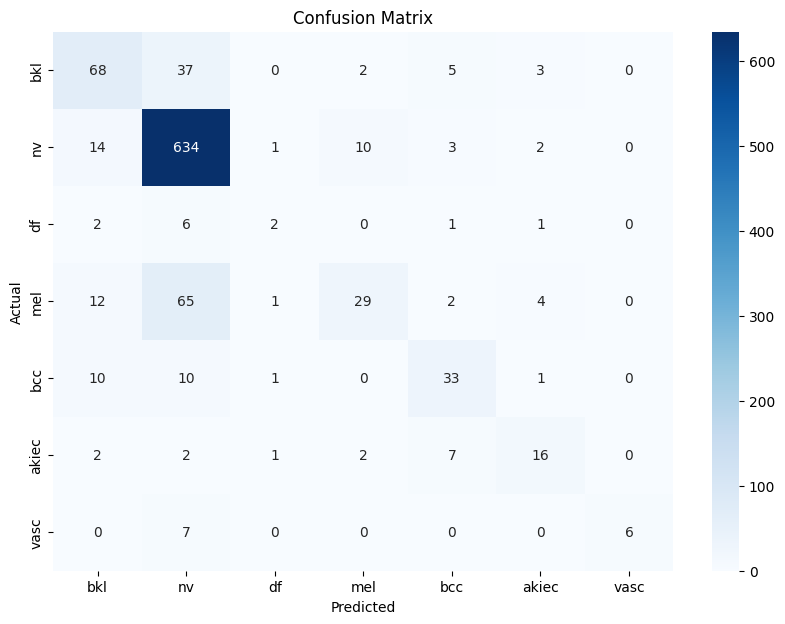

              precision    recall  f1-score   support

         bkl       0.63      0.59      0.61       115
          nv       0.83      0.95      0.89       664
          df       0.33      0.17      0.22        12
         mel       0.67      0.26      0.37       113
         bcc       0.65      0.60      0.62        55
       akiec       0.59      0.53      0.56        30
        vasc       1.00      0.46      0.63        13

    accuracy                           0.79      1002
   macro avg       0.67      0.51      0.56      1002
weighted avg       0.77      0.79      0.76      1002



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_name = 'densenet121'

cm = confusion_matrix(all_targets, all_predictions)
class_names = [key for key, value in mapping.items()]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
conf_matrix_filename = f'{model_name}_confusion_matrix.png'
plt.savefig(conf_matrix_filename)
plt.show()

print(classification_report(all_targets, all_predictions, target_names=class_names))